**Загрузка библиотек**

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})    # размер шрифта на графиках

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = 'D:/PythonProjectsData/LibrariesCourseProject/train.csv'
TEST_DATASET_PATH  = 'D:/PythonProjectsData/LibrariesCourseProject/test.csv'
SUBMIT_DATASET_PATH = 'D:/PythonProjectsData/LibrariesCourseProject/sample_submission.csv'
RESULT_DATASET_PATH = 'D:/PythonProjectsData/LibrariesCourseProject/submission.csv'

**Функции для работы с данными**

In [5]:
def transform_identifiers(X):
    X['Id'] = X['Id'].astype(str)
    X['DistrictId'] = X['DistrictId'].astype(str)
    #X['Id'] = X['Id'].astype(str)
    #X['DistrictId'] = X['DistrictId'].astype(str)
        
def print_name(name):
    print(f"\n{name}:")
    print('-' * (len(name) + 1) + '\n')
        
def print_info(name, X):
    print_name(name)
    print(f"{X.info()}")
        
def process_with_quantiles(X, field_name):
    return X[X[field_name].isnull() |
          (X[field_name] < X[field_name].quantile(.99)) &
          (X[field_name] > X[field_name].quantile(.01))]

def describe_wrong_square_balance(X):
    mask = X["Square"] < X["KitchenSquare"] + X["LifeSquare"]
    print(X.loc[mask].describe())
    
def calc_rest_square_median(X):
    return (X.loc[X['LifeSquare'].notnull(), 'Square'] -\
                  X.loc[X['LifeSquare'].notnull(), 'LifeSquare'] -\
                  X.loc[X['LifeSquare'].notnull(), 'KitchenSquare']).median()

def correct_wrong_lifesquare(X, median_value):
    X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] =\
    X.loc[X['LifeSquare'].isnull(), 'Square'] -\
    X.loc[X['LifeSquare'].isnull(), 'KitchenSquare'] - median_value
    
def correct_wrong_commonsquare(X, median_value):
    X.loc[X['Square'] < X["KitchenSquare"] + X["LifeSquare"], 'Square'] =\
    X["KitchenSquare"] + X["LifeSquare"] + median_value
    

### Загрузка данных
**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [7]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [9]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [10]:
names = ['Train', 'Test']
df = [train_df, test_df]

for i in range(2):
    print(f"{names[i]} shape (rows, cols): {df[i].shape}")

Train shape (rows, cols): (10000, 20)
Test shape (rows, cols): (5000, 19)


### Приведение идентификаторов к строковому типу

In [11]:
for i in range(2):
    print_info(names[i], df[i])


Train:
------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int6

In [12]:
for i in range(2):
    transform_identifiers(df[i])
    print_info(names[i], df[i])


Train:
------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int6

### Обзор данных
**Целевая переменная**

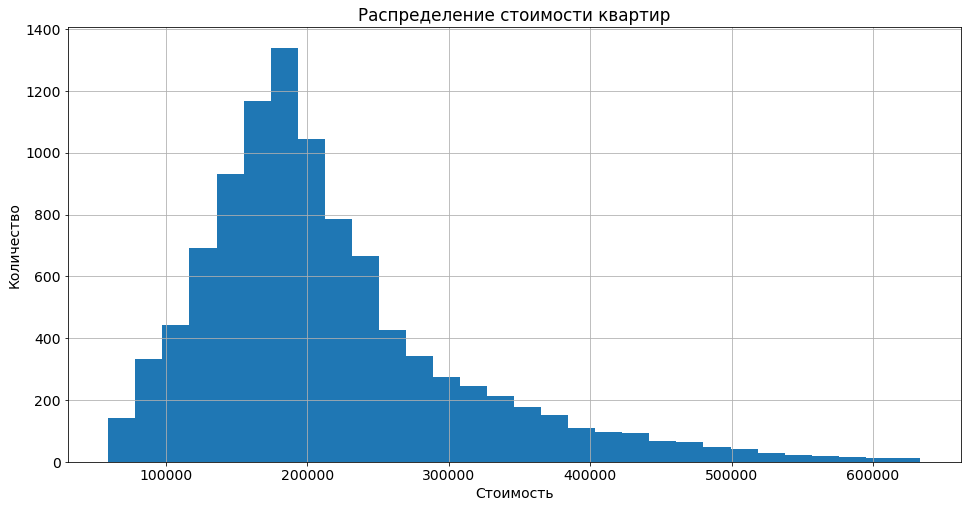

In [13]:
# логнормальное распределение
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Стоимость')

plt.title('Распределение стоимости квартир')
plt.show()

**Количественные переменные**

In [14]:
# Проверка выбросов данных
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [15]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


***Категориальные переменные***

In [16]:
# Количество значений категориальных переменных - для оценки

for i in range(2):
    cat_colnames = df[i].select_dtypes(include='object').columns.tolist()
    print(f"{names[i]}: {cat_colnames}\n")
    for cat_colname in cat_colnames[2:]:
        print(str(cat_colname) + '\n\n' + str(df[i][cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Train: ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************

Test: ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

Ecology_2

B    4952
A      48
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    4851
A     149
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    4588
A     412
Name: Shops_2, dtype: int64
*

### Обработка выбросов и замена пропусков
**Количество комнат**

In [17]:
for i in range(2):
    print_name(names[i])
    print(f"{df[i]['Rooms'].value_counts().reset_index().sort_values(by='index')}")


Train:
------

   index  Rooms
5    0.0      8
1    1.0   3705
0    2.0   3880
2    3.0   2235
3    4.0    150
4    5.0     18
7    6.0      1
6   10.0      2
8   19.0      1

Test:
-----

   index  Rooms
5    0.0      2
1    1.0   1769
0    2.0   2030
2    3.0   1099
3    4.0     90
4    5.0      7
6    6.0      2
7   17.0      1


In [18]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = int(train_df['Rooms'].median())
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = int(test_df['Rooms'].median())

In [19]:
for i in range(2):
    print_name(names[i])
    print(f"{df[i]['Rooms'].value_counts().reset_index().sort_values(by='index')}")


Train:
------

   index  Rooms
1    1.0   3705
0    2.0   3891
2    3.0   2235
3    4.0    150
4    5.0     18
5    6.0      1

Test:
-----

   index  Rooms
1    1.0   1769
0    2.0   2033
2    3.0   1099
3    4.0     90
4    5.0      7
5    6.0      2


**Площадь (кв. м): общая, жилая, кухни**

In [20]:
square = ['Square', 'LifeSquare', 'KitchenSquare']

#for j in range(3):
#    train_df = process_with_quantiles(train_df, square[j])
#    test_df = process_with_quantiles(test_df, square[j])

df[0] = train_df
df[1] = test_df

In [21]:
for i in range(2):
    print_info(names[i], df[i])


Train:
------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int6

In [22]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [23]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.90780,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.81008,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.00000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.00000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.00000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.00000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,6.00000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


**Подготовка базиса финального датасета к будущему объединению с тестовым (оставить только записи, ID для которых есть в тестовом)**

In [24]:
submit = pd.read_csv(SUBMIT_DATASET_PATH)
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


In [25]:
test_df['Id'] = test_df['Id'].astype(np.int64)
temp_id = test_df['Id'].reset_index().rename(columns={'index':'Ind', 'Id':'Id'})
print(temp_id.info())
submit = submit.merge(temp_id, on='Id', how='right')
submit = submit.drop(columns='Ind')
print(submit.info())
test_df['Id'] = test_df['Id'].astype(str)
df[1] = test_df
submit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Ind     5000 non-null   int64
 1   Id      5000 non-null   int64
dtypes: int64(2)
memory usage: 78.2 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 117.2 KB
None


,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [26]:
for k in range(3):
    for i in range(2):
        print_name(names[i])
        print(f"{df[i][square[k]].value_counts().reset_index().sort_values(by='index')}")


Train:
------

           index  Square
1423    1.136859       1
3677    1.988943       1
8920    2.377248       1
4154    2.596351       1
4554    2.954309       1
...          ...     ...
7120  212.932361       1
8838  275.645284       1
9422  409.425181       1
8479  604.705972       1
2219  641.065193       1

[10000 rows x 2 columns]

Test:
-----

           index  Square
4989    1.378543       1
4078    1.975769       1
811     2.372101       1
1686    2.645046       1
1198    2.900586       1
...          ...     ...
351   170.476326       1
4718  173.974480       1
2722  189.679576       1
2687  221.138768       1
33    223.453689       1

[5000 rows x 2 columns]

Train:
------

            index  LifeSquare
2377     0.370619           1
237      0.641822           1
4456     0.795539           1
4403     0.873147           1
2246     1.049867           1
...           ...         ...
2309   263.542020           1
493    410.639749           1
6900   461.463614           1
905

In [27]:
# Визуальный контроль нарушения пропорции "общая площадь не менее сумм жилой площади и площади кухни"
describe_wrong_square_balance(train_df)

            Rooms      Square   LifeSquare  KitchenSquare       Floor  \
count  845.000000  845.000000   845.000000     845.000000  845.000000   
mean     1.766864   59.145433    68.782054      11.160947    9.797633   
std      0.824012   32.663061   257.842899      97.293152    6.024869   
min      1.000000    1.136859     1.626502       0.000000    1.000000   
25%      1.000000   41.481906    41.675761       1.000000    5.000000   
50%      2.000000   53.258610    53.983730       1.000000    8.000000   
75%      2.000000   68.767146    68.712203      10.000000   14.000000   
max      5.000000  641.065193  7480.592129    2014.000000   28.000000   

       HouseFloor    HouseYear   Ecology_1    Social_1      Social_2  \
count  845.000000   845.000000  845.000000  845.000000    845.000000   
mean    14.101775  2000.353846    0.105389   16.360947   3771.007101   
std      8.652264    19.752893    0.109640   17.079439   3982.369298   
min      0.000000  1918.000000    0.000000    0.000000

In [28]:
describe_wrong_square_balance(test_df)

            Rooms      Square  LifeSquare  KitchenSquare       Floor  \
count  438.000000  438.000000  438.000000     438.000000  438.000000   
mean     1.835616   58.197018   58.693033       7.527397    9.602740   
std      0.800692   21.217462   24.366009      31.086105    5.769579   
min      1.000000    1.378543    1.353573       0.000000    1.000000   
25%      1.000000   42.109891   42.428408       1.000000    5.000000   
50%      2.000000   56.290501   56.831947       1.000000    9.000000   
75%      2.000000   68.411764   69.022050      10.000000   13.000000   
max      4.000000  168.729035  303.071094     620.000000   26.000000   

       HouseFloor    HouseYear   Ecology_1    Social_1      Social_2  \
count  438.000000   438.000000  438.000000  438.000000    438.000000   
mean    14.331050  1997.458904    0.102266   16.632420   3784.803653   
std      8.007862    20.533990    0.112392   17.049384   3876.607236   
min      0.000000  1909.000000    0.000000    0.000000    168.0

In [29]:
# Замена чрезмерно малых (чрезмерно больших нет) площадей жилой и кухни на "хрущёвские" пороговые значения (кв. м)
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10
test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [30]:
for k in range(3):
    for i in range(2):
        print_name(names[i])
        print(f"{df[i][square[k]].value_counts().reset_index().sort_values(by='index')}")


Train:
------

           index  Square
1423    1.136859       1
3677    1.988943       1
8920    2.377248       1
4154    2.596351       1
4554    2.954309       1
...          ...     ...
7120  212.932361       1
8838  275.645284       1
9422  409.425181       1
8479  604.705972       1
2219  641.065193       1

[10000 rows x 2 columns]

Test:
-----

           index  Square
4989    1.378543       1
4078    1.975769       1
811     2.372101       1
1686    2.645046       1
1198    2.900586       1
...          ...     ...
351   170.476326       1
4718  173.974480       1
2722  189.679576       1
2687  221.138768       1
33    223.453689       1

[5000 rows x 2 columns]

Train:
------

            index  LifeSquare
0       10.000000         205
7552    10.523868           1
6276    10.651455           1
1879    10.845368           1
6747    10.924281           1
...           ...         ...
2247   263.542020           1
317    410.639749           1
6244   461.463614           1
569

In [31]:
# Повторный визуальный контроль нарушения пропорции "общая площадь не менее сумм жилой площади и площади кухни"
describe_wrong_square_balance(train_df)

             Rooms       Square   LifeSquare  KitchenSquare        Floor  \
count  1207.000000  1207.000000  1207.000000    1207.000000  1207.000000   
mean      1.774648    59.788790    65.832839      10.973488     9.725766   
std       0.803549    29.797460   216.066250      81.308490     5.893487   
min       1.000000     1.136859    10.000000       5.000000     1.000000   
25%       1.000000    42.357592    41.772925       5.000000     5.000000   
50%       2.000000    55.536046    54.710658       5.000000     9.000000   
75%       2.000000    70.350465    69.388719       8.000000    14.000000   
max       5.000000   641.065193  7480.592129    2014.000000    28.000000   

        HouseFloor    HouseYear    Ecology_1     Social_1      Social_2  \
count  1207.000000  1207.000000  1207.000000  1207.000000   1207.000000   
mean     13.857498  1999.414250     0.106823    15.262635   3548.437448   
std       8.757157    19.762497     0.113419    16.512565   3845.933941   
min       0.000

In [32]:
# Контроль медианы жилой площади
for i in range(2):
    print(f'{names[i]}: median = {df[i]["LifeSquare"].median()}')

Train: median = 32.781260192155735
Test: median = 32.92508663208161


In [33]:
# Медиана суммарной площади прихожей, коридоров, санузла, ванной комнаты
square_med_diff = []
for i in range(2):
    square_med_diff.append(calc_rest_square_median(df[i]))
print(square_med_diff[0], square_med_diff[1])

11.352485256083003 11.375106327586241


In [34]:
# Коррекция жилой площади
for i in range(2):
    correct_wrong_lifesquare(df[i], square_med_diff[i])

In [35]:
# Повторный контроль медианы жилой площади
for i in range(2):
    print(f'{names[i]}: median = {df[i]["LifeSquare"].median()}')

Train: median = 33.600658244503514
Test: median = 33.86792766338292


In [36]:
mask = train_df["Square"] < train_df["KitchenSquare"] + train_df["LifeSquare"]
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,442.000000,1207.000000,1207.000000,1207.000000
mean,1.774648,59.788790,65.832839,10.973488,9.725766,13.857498,1999.414250,0.106823,15.262635,3548.437448,8.777133,857.027149,0.813587,3.434134,196237.454285
std,0.803549,29.797460,216.066250,81.308490,5.893487,8.757157,19.762497,0.113419,16.512565,3845.933941,29.557475,690.111920,1.331173,5.322791,94611.113111
min,1.000000,1.136859,10.000000,5.000000,1.000000,0.000000,1918.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,59877.592523
25%,1.000000,42.357592,41.772925,5.000000,5.000000,9.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,132037.613409
50%,2.000000,55.536046,54.710658,5.000000,9.000000,17.000000,2014.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,175042.816715
75%,2.000000,70.350465,69.388719,8.000000,14.000000,17.000000,2017.000000,0.195781,25.000000,5735.000000,3.000000,1046.000000,1.000000,5.000000,232366.110506
max,5.000000,641.065193,7480.592129,2014.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,4508.000000,6.000000,23.000000,621002.912679


In [37]:
# Коррекция общей площади
for i in range(2):
    correct_wrong_commonsquare(df[i], square_med_diff[i])

In [38]:
# Повторный контроль выбросов общей площади
for i in range(2):
    print_name(names[i])
    describe_wrong_square_balance(df[i])


Train:
------

       Rooms  Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
count    0.0     0.0         0.0            0.0    0.0         0.0        0.0   
mean     NaN     NaN         NaN            NaN    NaN         NaN        NaN   
std      NaN     NaN         NaN            NaN    NaN         NaN        NaN   
min      NaN     NaN         NaN            NaN    NaN         NaN        NaN   
25%      NaN     NaN         NaN            NaN    NaN         NaN        NaN   
50%      NaN     NaN         NaN            NaN    NaN         NaN        NaN   
75%      NaN     NaN         NaN            NaN    NaN         NaN        NaN   
max      NaN     NaN         NaN            NaN    NaN         NaN        NaN   

       Ecology_1  Social_1  Social_2  Social_3  Healthcare_1  Helthcare_2  \
count        0.0       0.0       0.0       0.0           0.0          0.0   
mean         NaN       NaN       NaN       NaN           NaN          NaN   
std          NaN       

In [39]:
# Контроль "нулевой" суммарной площади коридоров, прихожей и т.д.
mask = train_df["Square"] - train_df["KitchenSquare"] - train_df["LifeSquare"] == 0
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
mask = test_df["Square"] - test_df["KitchenSquare"] - test_df["LifeSquare"] == 0
test_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Повторный контроль пропусков (жилая площадь должна быть без пропусков)
for i in range(2):
    print_info(names[i], df[i])


Train:
------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int6

**Этаж квартиры и количество этажей в доме**

In [42]:
# Контроль взаимного несоответствия этажей расположения квартиры и количества этажей в доме
mask = train_df["Floor"] > train_df["HouseFloor"]
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,861.000000,1825.000000,1825.000000,1825.000000
mean,1.892055,64.109918,41.572305,8.511781,10.712877,6.185205,1983.400000,0.110328,21.010411,4601.012603,9.060274,1106.375145,1.208767,3.972055,211728.724007
std,0.819758,70.806273,26.621836,65.806510,5.761504,6.314379,18.795734,0.110829,17.035483,3824.698649,27.271030,988.414587,1.487790,5.142145,96080.348949
min,1.000000,20.924926,10.000000,5.000000,1.000000,0.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,60828.260686
25%,1.000000,44.346316,25.312739,5.000000,6.000000,1.000000,1976.000000,0.017647,2.000000,629.000000,0.000000,520.000000,0.000000,0.000000,148991.265200
50%,2.000000,57.768585,36.626949,5.000000,10.000000,5.000000,1977.000000,0.072158,22.000000,4724.000000,1.000000,990.000000,1.000000,2.000000,188118.364308
75%,2.000000,74.229460,50.328034,7.000000,15.000000,9.000000,1994.000000,0.174739,32.000000,6398.000000,4.000000,1450.000000,2.000000,5.000000,241941.307245
max,5.000000,2071.800445,638.163193,2014.000000,28.000000,25.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,627525.072788


In [43]:
mask = test_df["Floor"] > test_df["HouseFloor"]
test_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,884.000000,431.000000,884.000000,884.000000
mean,1.878959,60.862605,40.354517,6.136878,11.054299,6.563348,1983.346154,0.115746,21.324661,4645.315611,9.872172,1058.638051,1.252262,4.132353
std,0.794979,21.866630,21.266133,2.859970,6.444589,6.704020,18.552246,0.113698,16.811924,3716.158096,28.354785,986.161183,1.506778,5.269145
min,1.000000,21.452899,10.000000,5.000000,2.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000
25%,1.000000,44.696464,25.477123,5.000000,6.000000,1.000000,1975.000000,0.019509,4.000000,915.000000,0.000000,325.000000,0.000000,0.000000
50%,2.000000,56.732127,34.724455,5.000000,10.000000,5.000000,1977.000000,0.072158,23.000000,4860.000000,1.000000,800.000000,1.000000,2.000000
75%,2.000000,74.923609,49.850724,6.000000,15.000000,12.000000,1991.250000,0.194489,33.000000,6566.000000,5.000000,1331.000000,3.000000,5.000000
max,5.000000,186.276808,169.901701,57.000000,78.000000,26.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4702.000000,6.000000,23.000000


In [44]:
# Какие вообще имеются значения
for i in range(2):
    print_name(names[i])
    print(f"Количество этажей в доме: {df[i]['HouseFloor'].sort_values().unique()}\n")
    print(f"Этаж квартиры: {df[i]['Floor'].sort_values().unique()}\n")
    print(f"Медиана количества этажей в доме: {df[i]['HouseFloor'].median()}")
    print(f"Мода количества этажей в доме: {df[i]['HouseFloor'].mode()}")



Train:
------

Количество этажей в доме: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  36.  37.  38.  39.  40.  44.  45.  47.  48.
  99. 117.]

Этаж квартиры: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 31 32 33 37 42]

Медиана количества этажей в доме: 13.0
Мода количества этажей в доме: 0    17.0
dtype: float64

Test:
-----

Количество этажей в доме: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 36.
 37. 39. 40. 48. 99.]

Этаж квартиры: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 31 32 33 34 38 46 78]

Медиана количества этажей в доме: 12.0
Мода количества этажей в доме: 0    17.0
dtype: float64


In [45]:
for i in range(2):
    print_name(names[i])
    print(f"{df[i]['HouseFloor'].value_counts().reset_index().sort_values(by='index')}")


Train:
------

    index  HouseFloor
9     0.0         269
6     1.0         497
21    2.0          48
14    3.0         127
13    4.0         134
3     5.0        1031
20    6.0          58
19    7.0          59
11    8.0         141
1     9.0        1389
12   10.0         135
24   11.0          28
2    12.0        1074
25   13.0          27
4    14.0         625
15   15.0         123
5    16.0         576
0    17.0        2331
18   18.0          89
16   19.0         108
17   20.0         105
23   21.0          33
8    22.0         343
22   23.0          40
10   24.0         176
7    25.0         374
43   26.0           1
28   27.0           6
31   28.0           3
35   29.0           1
26   30.0          21
39   31.0           1
30   32.0           4
38   36.0           1
29   37.0           4
40   38.0           1
32   39.0           2
27   40.0           7
36   44.0           1
42   45.0           1
37   47.0           1
33   48.0           2
34   99.0           2
41  117.0       

In [46]:
# Коррекция нулевой и очень высокой этажности
for i in range(2):
    df[i].loc[df[i]['HouseFloor'] == 0, 'HouseFloor'] = df[i]['HouseFloor'].median()
    df[i].loc[df[i]['HouseFloor'] > 100, 'HouseFloor'] = df[i]['HouseFloor'].median()
    print_name(names[i])
    print(f"Количество этажей в доме: {df[i]['HouseFloor'].sort_values().unique()}")


Train:
------

Количество этажей в доме: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 36. 37. 38. 39.
 40. 44. 45. 47. 48. 99.]

Test:
-----

Количество этажей в доме: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 36. 37.
 39. 40. 48. 99.]


In [47]:
# Коррекция этажей квартиры, превышающих количество этажей в доме
for i in range(2):
    wrong_floor_cond = df[i][df[i]['Floor'] > df[i]['HouseFloor']].index
    df[i].loc[wrong_floor_cond, 'Floor'] = df[i].loc[wrong_floor_cond, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [48]:
# Повторный контроль взаимного несоответствия этажей расположения квартиры и количества этажей в доме
mask = train_df["Floor"] > train_df["HouseFloor"]
train_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
mask = test_df["Floor"] > test_df["HouseFloor"]
test_df.loc[mask].describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Год постройки дома**

In [50]:
train_df['HouseYear'].value_counts().sort_index()

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [51]:
test_df['HouseYear'].value_counts().sort_index()

1908      1
1909      1
1910      1
1911      1
1912      1
       ... 
2016    172
2017    141
2018     73
2019     28
2020      9
Name: HouseYear, Length: 97, dtype: int64

In [52]:
# Коррекция года постройки дома
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)

In [53]:
train_df['HouseYear'].value_counts().sort_index()

1910      1
1912      2
1914      1
1916      1
1917      3
       ... 
2016    305
2017    308
2018    175
2019     79
2020     19
Name: HouseYear, Length: 95, dtype: int64

In [54]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,59.740037,38.694618,7.615300,7.390100,12.948700,1984.86600,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.812096,82.744936,77.298492,28.369201,5.028225,6.358892,18.41187,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,16.117154,-8.493244,5.000000,1.000000,1.000000,1910.00000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,42.520445,23.745440,5.000000,3.000000,9.000000,1974.00000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,55.106163,33.600658,6.000000,6.000000,13.000000,1977.00000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,68.503352,46.788458,9.000000,11.000000,17.000000,2001.00000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,6.000000,7496.944614,7480.592129,2014.000000,42.000000,99.000000,2020.00000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [55]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.90780,58.812377,37.864758,7.275600,7.492400,12.915400,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.81008,22.394985,18.081593,9.448296,5.143348,6.468617,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.00000,16.319015,-10.049063,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.00000,42.816005,23.940314,5.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.00000,55.351625,33.867928,6.000000,6.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.00000,69.498655,47.101318,9.000000,10.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,6.00000,655.598876,303.071094,620.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


**Здравоохранение 1**

In [56]:
for i in range(2):
    df[i].loc[df[i]['Healthcare_1'].isnull(), 'Healthcare_1'] = df[i]['Healthcare_1'].median()

### Ввод новых признаков
**Замена категориальных переменных (не идентификаторов) числовыми значениями**

In [57]:
for i in range(2):
    df[i]['Ecology_2'] = df[i]['Ecology_2'].replace({'A':0, 'B':1}).astype(int)
    df[i]['Ecology_3'] = df[i]['Ecology_3'].replace({'A':0, 'B':1}).astype(int)
    df[i]['Shops_2'] = df[i]['Shops_2'].replace({'A':0, 'B':1}).astype(int)

In [58]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,59.740037,38.694618,7.615300,7.390100,12.948700,1984.86600,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,0.812096,82.744936,77.298492,28.369201,5.028225,6.358892,18.41187,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,1.000000,16.117154,-8.493244,5.000000,1.000000,1.000000,1910.00000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,42.520445,23.745440,5.000000,3.000000,9.000000,1974.00000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,2.000000,55.106163,33.600658,6.000000,6.000000,13.000000,1977.00000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,2.000000,68.503352,46.788458,9.000000,11.000000,17.000000,2001.00000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,6.000000,7496.944614,7480.592129,2014.000000,42.000000,99.000000,2020.00000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [59]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.90780,58.812377,37.864758,7.275600,7.492400,12.915400,1984.392600,0.119874,0.990400,0.970200,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.917600
std,0.81008,22.394985,18.081593,9.448296,5.143348,6.468617,18.573149,0.120070,0.097518,0.170052,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.275001
min,1.00000,16.319015,-10.049063,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.00000,42.816005,23.940314,5.000000,4.000000,9.000000,1973.000000,0.019509,1.000000,1.000000,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000
50%,2.00000,55.351625,33.867928,6.000000,6.000000,12.000000,1977.000000,0.072158,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000
75%,2.00000,69.498655,47.101318,9.000000,10.000000,17.000000,2000.000000,0.195781,1.000000,1.000000,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000
max,6.00000,655.598876,303.071094,620.000000,46.000000,99.000000,2020.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000


In [60]:
for i in range(2):
    print_info(names[i], df[i])


Train:
------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int32  
 11  Ecology_3      10000 non-null  int32  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int6

**DistrictSize, IsDistrictLarge**

In [61]:
for i in range(2):
    district_size = df[i]['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    print_name(names[i])
    print(district_size.head())
    if i == 0:
        train_df = train_df.merge(district_size, on='DistrictId', how='left')
    else:
        test_df = test_df.merge(district_size, on='DistrictId', how='left')


Train:
------

  DistrictId  DistrictSize
0         27           851
1          1           652
2         23           565
3          6           511
4          9           294

Test:
-----

  DistrictId  DistrictSize
0         27           391
1          1           344
2         23           264
3          6           257
4          9           132


In [62]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    X['year_cat'].fillna(-1, inplace=True)
    return X

def process_district_size(X):
    X['new_district'] = 0
    X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
    X['DistrictSize'].fillna(5, inplace=True)
    return X

In [63]:
train_df = process_district_size(train_df)
test_df = process_district_size(test_df)

df[0] = train_df
df[1] = test_df

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,new_district
0,11809,27,3.0,115.027311,93.674825,10.0,4,10.0,2014,0.075424,...,11,3097,0,900.0,0,0,1,305018.871089,851,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,1,177734.553407,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,1,282078.720850,652,0
3,2352,1,1.0,40.409907,24.057422,5.0,10,22.0,1977,0.007122,...,1,264,0,900.0,0,1,1,168106.007630,652,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,33,8667,2,900.0,0,6,1,343995.102962,89,0


In [64]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize,new_district
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1,24,4378,0,1036.0,1,1,1,46,0
1,5925,62,1.0,63.943239,42.568133,10.0,7,17.0,2017,0.072158,...,1,2,629,1,900.0,0,0,0,122,0
2,960,27,2.0,59.463678,39.088572,9.0,19,19.0,1977,0.211401,...,1,9,1892,0,900.0,0,1,1,391,0
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,1,2,475,0,900.0,0,0,1,264,0
4,746,74,1.0,53.837056,37.461949,5.0,8,17.0,1977,0.309479,...,1,35,7715,4,990.0,0,6,1,61,0


In [65]:
for i in range(2):
    print_name(names[i])
    print((df[i]['DistrictSize'] > 100).value_counts())


Train:
------

True     5069
False    4931
Name: DistrictSize, dtype: int64

Test:
-----

False    3375
True     1625
Name: DistrictSize, dtype: int64


In [66]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

In [67]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,new_district,IsDistrictLarge
0,11809,27,3.0,115.027311,93.674825,10.0,4,10.0,2014,0.075424,...,3097,0,900.0,0,0,1,305018.871089,851,0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.553407,78,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,1,282078.720850,652,0,1
3,2352,1,1.0,40.409907,24.057422,5.0,10,22.0,1977,0.007122,...,264,0,900.0,0,1,1,168106.007630,652,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,900.0,0,6,1,343995.102962,89,0,0


In [68]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize,new_district,IsDistrictLarge
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,24,4378,0,1036.0,1,1,1,46,0,0
1,5925,62,1.0,63.943239,42.568133,10.0,7,17.0,2017,0.072158,...,2,629,1,900.0,0,0,0,122,0,1
2,960,27,2.0,59.463678,39.088572,9.0,19,19.0,1977,0.211401,...,9,1892,0,900.0,0,1,1,391,0,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,2,475,0,900.0,0,0,1,264,0,1
4,746,74,1.0,53.837056,37.461949,5.0,8,17.0,1977,0.309479,...,35,7715,4,990.0,0,6,1,61,0,0


**MedPriceByDistrict**

In [69]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [70]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,93.674825,10.0,4,10.0,2014,0.075424,...,0,900.0,0,0,1,305018.871089,851,0,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,1,177734.553407,78,0,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,1,282078.720850,652,0,1,244005.272380
3,2352,1,1.0,40.409907,24.057422,5.0,10,22.0,1977,0.007122,...,0,900.0,0,1,1,168106.007630,652,0,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,900.0,0,6,1,343995.102962,89,0,0,201584.441255


In [71]:
test_df = test_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,4378,0,1036.0,1,1,1,46,0,0,171145.169069
1,5925,62,1.0,63.943239,42.568133,10.0,7,17.0,2017,0.072158,...,629,1,900.0,0,0,0,122,0,1,129107.218932
2,960,27,2.0,59.463678,39.088572,9.0,19,19.0,1977,0.211401,...,1892,0,900.0,0,1,1,391,0,1,165700.355193
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,475,0,900.0,0,0,1,264,0,1,166687.735824
4,746,74,1.0,53.837056,37.461949,5.0,8,17.0,1977,0.309479,...,7715,4,990.0,0,6,1,61,0,0,165071.825722


**MedPriceByFloorYear**

In [72]:
df[0] = train_df
df[1] = test_df

In [73]:
for i in range(2):
    bins = [0, 3, 5, 9, 15, df[i]['Floor'].max()]
    print_name(names[i])
    print(pd.cut(df[i]['Floor'], bins=bins, labels=False))


Train:
------

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

Test:
-----

0       1
1       2
2       4
3       0
4       2
       ..
4995    0
4996    4
4997    0
4998    2
4999    2
Name: Floor, Length: 5000, dtype: int64


In [74]:
for i in range(2):
    bins = [0, 3, 5, 9, 15, df[i]['Floor'].max()]
    print_name(names[i])
    print(pd.cut(df[i]['Floor'], bins=bins))


Train:
------

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

Test:
-----

0         (3, 5]
1         (5, 9]
2       (15, 46]
3         (0, 3]
4         (5, 9]
          ...   
4995      (0, 3]
4996    (15, 46]
4997      (0, 3]
4998      (5, 9]
4999      (5, 9]
Name: Floor, Length: 5000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 46]]


In [75]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
test_df = year_to_cat(test_df)
test_df = floor_to_cat(test_df)

In [76]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,93.674825,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,851,0,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,78,0,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,652,0,1,244005.272380,4,1
3,2352,1,1.0,40.409907,24.057422,5.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,652,0,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,89,0,0,201584.441255,3,5


In [77]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1036.0,1,1,1,46,0,0,171145.169069,3,2
1,5925,62,1.0,63.943239,42.568133,10.0,7,17.0,2017,0.072158,...,900.0,0,0,0,122,0,1,129107.218932,6,3
2,960,27,2.0,59.463678,39.088572,9.0,19,19.0,1977,0.211401,...,900.0,0,1,1,391,0,1,165700.355193,3,5
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,900.0,0,0,1,264,0,1,166687.735824,3,1
4,746,74,1.0,53.837056,37.461949,5.0,8,17.0,1977,0.309479,...,990.0,0,6,1,61,0,0,165071.825722,3,3


In [78]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,344914.843683
1,1,2,333877.704698
2,1,3,421756.290145
3,1,4,274992.472366
4,2,1,467230.539057


In [79]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,93.674825,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,851,0,1,213530.788443,6,2,161825.406053
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,78,0,0,146032.829834,3,3,192448.500518
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,652,0,1,244005.272380,4,1,205635.009743
3,2352,1,1.0,40.409907,24.057422,5.0,10,22.0,1977,0.007122,...,1,1,168106.007630,652,0,1,146735.671740,3,4,183595.406754
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,89,0,0,201584.441255,3,5,173934.865013


In [80]:
test_df = test_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
test_df.loc[test_df['MedPriceByFloorYear'].isnull(), 'MedPriceByFloorYear'] = test_df['MedPriceByFloorYear'].median()
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,1,1,1,46,0,0,171145.169069,3,2,188584.132829
1,5925,62,1.0,63.943239,42.568133,10.0,7,17.0,2017,0.072158,...,0,0,0,122,0,1,129107.218932,6,3,173472.709373
2,960,27,2.0,59.463678,39.088572,9.0,19,19.0,1977,0.211401,...,0,1,1,391,0,1,165700.355193,3,5,173934.865013
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,0,0,1,264,0,1,166687.735824,3,1,179328.179342
4,746,74,1.0,53.837056,37.461949,5.0,8,17.0,1977,0.309479,...,0,6,1,61,0,0,165071.825722,3,3,192448.500518


In [81]:
df[0] = train_df
df[1] = test_df
for i in range(2):
    print_info(names[i], df[i])


Train:
------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   10000 non-null  object 
 1   DistrictId           10000 non-null  object 
 2   Rooms                10000 non-null  float64
 3   Square               10000 non-null  float64
 4   LifeSquare           10000 non-null  float64
 5   KitchenSquare        10000 non-null  float64
 6   Floor                10000 non-null  int64  
 7   HouseFloor           10000 non-null  float64
 8   HouseYear            10000 non-null  int64  
 9   Ecology_1            10000 non-null  float64
 10  Ecology_2            10000 non-null  int32  
 11  Ecology_3            10000 non-null  int32  
 12  Social_1             10000 non-null  int64  
 13  Social_2             10000 non-null  int64  
 14  Social_3             10000 non-null  int64  
 15  Healthcare_1         

### Разбиение датасета на train и test

In [82]:
target_name = 'Price'

In [83]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=False, random_state=21)

In [85]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [86]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

In [87]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [88]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['DistrictSize', 'new_district', 'IsDistrictLarge', 'MedPriceByDistrict', 'MedPriceByFloorYear']

In [89]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [90]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели
**Обучение**

In [91]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')

**Оценка модели**

In [92]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Предсказание на Train')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Предсказание на Test')

    plt.show()
    
def predict_with_model(model):
    global X_train, X_valid, y_train, y_valid
    model.fit(X_train, y_train)
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_valid)
    evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)    

Train R2:	0.964
Test R2:	0.75


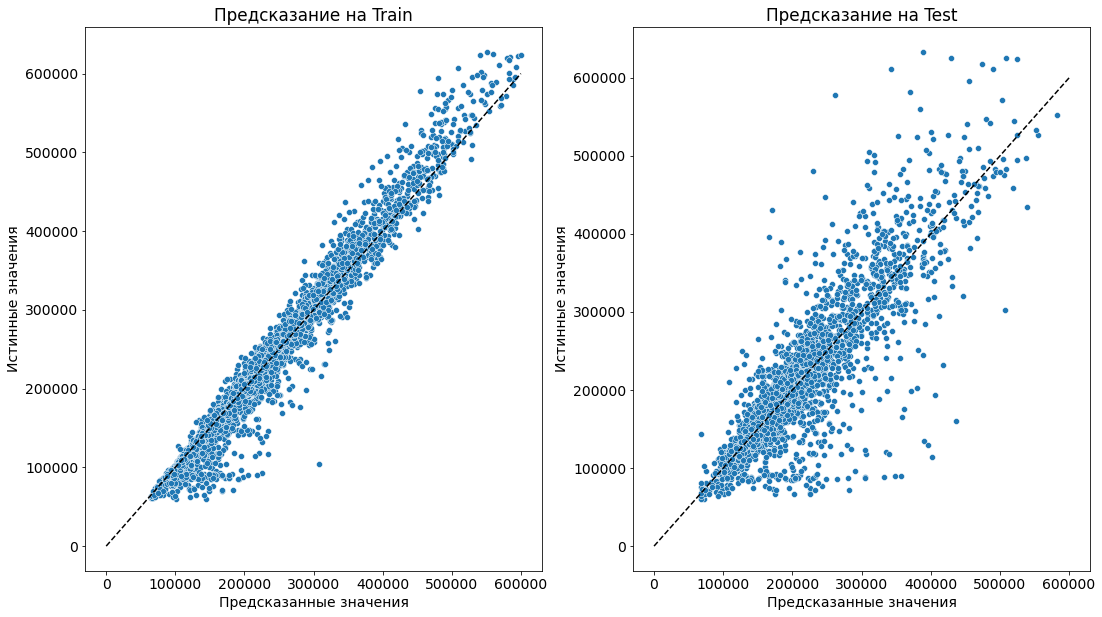

In [93]:
predict_with_model(rf_model)

**Другие модели**

In [94]:
from sklearn.ensemble import StackingRegressor, BaggingRegressor, GradientBoostingRegressor

#lr = LinearRegression()
#gb = GradientBoostingRegressor()

#stack = StackingRegressor([('lr', lr), ('rf', rf_model)], final_estimator=gb)

In [95]:
#predict_with_model(stack)

In [96]:
#br = BaggingRegressor(random_state=21, n_estimators=300)
#predict_with_model(br)

In [97]:
#predict_with_model(lr)

In [98]:
#dt_model = DecisionTreeRegressor(criterion='mse', max_depth=100, min_samples_leaf=60, random_state=21)
#predict_with_model(dt_model)

In [99]:
#gb_model = GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=2, random_state=21, n_estimators=100)
#predict_with_model(gb_model)

***Краткие результаты прогона разных моделей (критерий MSE)***

In [100]:
mod_res = []
mod_res.append(["BaggingRegressor(random_state=21, n_estimators=300)", 0.964, 0.746])
mod_res.append(["RandomForestRegressor(random_state=21, criterion='mse')", 0.963, 0.746])
mod_res.append(["GradientBoostingRegressor(max_depth=7, min_samples_leaf=2, random_state=21, n_estimators=100)", 0.943, 0.679])
mod_res.append(["StackingRegressor(lr, rf, gb)", 0.884, 0.732])
mod_res.append(["DecisionTreeRegressor(max_depth=100, min_samples_leaf=60, random_state=21)", 0.715, 0.679])
mod_res.append(["LinearRegression", 0.707, 0.696])

print(f"\n{'Наименование модели':<100}{'Train R2':<15}{'Test R2'}")
print("-"*122)
for i in range(len(mod_res)):
    print(f"{i+1}. {mod_res[i][0]:<98}{mod_res[i][1]:<15}{mod_res[i][2]}")
    
print(f"\nПо совокупности значений R2 для train {mod_res[1][1]} и test {mod_res[1][2]} и скорости вычислений лучшей признана модель\n{mod_res[1][0]}")
print("\nТехника работы с GridSearchCV была опробована однократно в учебно-ознакомительных целях.")


Наименование модели                                                                                 Train R2       Test R2
--------------------------------------------------------------------------------------------------------------------------
1. BaggingRegressor(random_state=21, n_estimators=300)                                               0.964          0.746
2. RandomForestRegressor(random_state=21, criterion='mse')                                           0.963          0.746
3. GradientBoostingRegressor(max_depth=7, min_samples_leaf=2, random_state=21, n_estimators=100)     0.943          0.679
4. StackingRegressor(lr, rf, gb)                                                                     0.884          0.732
5. DecisionTreeRegressor(max_depth=100, min_samples_leaf=60, random_state=21)                        0.715          0.679
6. LinearRegression                                                                                  0.707          0.696

По совокупности знач

**Предсказание на лучшей модели, последующее объединение с submit и сохранение результата в целевой файл**

In [101]:
best_model = rf_model
feature_importances = pd.DataFrame(zip(test_df.columns, best_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances.head(3)

,feature_name,importance
20,MedPriceByDistrict,0.635232
1,Square,0.098342
2,LifeSquare,0.035261


In [102]:
feature_importances.tail(3)

,feature_name,importance
9,Ecology_3,0.000660
8,Ecology_2,0.000281
18,new_district,0.000000


In [103]:
predictions = best_model.predict(test_df)
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162419.066683
1,5925,124401.349288
2,960,146500.801505
3,3848,155460.479682
4,746,168105.782540


In [104]:
submit.to_csv(RESULT_DATASET_PATH, index=False)

In [105]:
#from sklearn.model_selection import KFold, GridSearchCV

#%%time
#params = {'n_estimators':[50, 100, 200, 400], 
#          'max_depth':[3, 5, 7, 10]}

#gs = GridSearchCV(rf_model, params, scoring='r2', cv=KFold(n_splits=5, random_state=21, shuffle=True), n_jobs=-1)

In [106]:
#res = pd.DataFrame(gs.cv_results_)
#print(res.head(2))
#print(gs.best_params_)
#print(gs.best_score_)